In [233]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDRegressor, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from warnings import filterwarnings

filterwarnings("ignore")

## 1 - Prepare data

In [234]:
# 1 Version
import pandas as pd

def convert_column_to_numeric(df, column_name):
    """
    Fonction pour traiter et convertir une colonne en type numérique.
    Remplace les virgules par des points, puis convertit en numérique.
    """
    if column_name in df.columns:
        # Remplacer les virgules par des points
        df[column_name] = df[column_name].apply(lambda x: str(x).replace(',', '.'))
        # Convertir en numérique
        df[column_name] = pd.to_numeric(df[column_name], errors="coerce")
        print(f"Colonne '{column_name}' convertie.")
    return df

def convert_columns_with_numeric_values(df):
    """
    Parcourt toutes les colonnes du DataFrame et effectue les actions suivantes :
    1. Supprime les espaces autour des noms de colonnes.
    2. Supprime les colonnes spécifiques ["Unnamed: 21", "Citation", "Citation Link", "Protein"] si elles existent.
    3. Convertit les colonnes contenant uniquement des valeurs numériques sous forme de chaînes en type numérique.
    4. Applique la conversion sur les colonnes spécifiques.
    5. Supprime les doublons du DataFrame.
    
    Args:
    - df : DataFrame à traiter
    
    Returns:
    - DataFrame avec les colonnes modifiées et les doublons supprimés.
    """
    # Supprimer les espaces autour des noms de colonnes
    df.columns = df.columns.str.strip()
    
    # Supprimer les colonnes spécifiques si elles existent
    columns_to_drop = [
        'Citation',
        'Citation Link',
        'Protein',
        'Unnamed: 21'
    ]
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)
    print("Colonnes 'Unnamed: 21', 'Citation', 'Citation Link', et 'Protein' supprimées si elles existaient.")
    
    # Colonnes spécifiques à traiter de manière identique
    columns_to_convert = [
        'Hardness/firmness/strength (g)',
        'Protein Concentration (%)',
        'Additives',
        'If a gel can be formed (0-1)',
        'Additives Concentration (%)',
        'ionic strength (M)',
        'pH',
        'Treatment condition value'
    ]
    
    # Appliquer la conversion à ces colonnes
    for col in columns_to_convert:
        df = convert_column_to_numeric(df, col)
    
    # Supprimer les doublons
    df.drop_duplicates(inplace=True)
    print("Doublons supprimés.")
    
    return df

# Exemple d'utilisation :
df = pd.read_csv(r"C:\Users\harri\ai_bobby_repository\data\raw\Hardness.csv", sep=";")
df = convert_columns_with_numeric_values(df)

# Vérification des colonnes modifiées
print(df.head())

Colonnes 'Unnamed: 21', 'Citation', 'Citation Link', et 'Protein' supprimées si elles existaient.
Colonne 'Hardness/firmness/strength (g)' convertie.
Colonne 'Protein Concentration (%)' convertie.
Colonne 'Additives' convertie.
Colonne 'If a gel can be formed (0-1)' convertie.
Colonne 'Additives Concentration (%)' convertie.
Colonne 'ionic strength (M)' convertie.
Colonne 'pH' convertie.
Colonne 'Treatment condition value' convertie.
Doublons supprimés.
   Protein codes  Protein Concentration (%)  Treatment code  \
0          10501                      12.00             NaN   
1          10501                      12.00             NaN   
2          10501                      12.00             NaN   
3          10501                      12.00             NaN   
4          10501                      12.00             NaN   

   Treatment condition code  Treatment condition value  \
0                       NaN                        NaN   
1                       NaN                    

In [235]:
df.shape

(1073, 18)

In [5]:
df['pH'].value_counts()

pH
7.00     397
6.50      72
6.00      47
9.00      32
8.00      32
        ... 
8.34       1
6.84       1
8.88       1
6.87       1
11.08      1
Name: count, Length: 71, dtype: int64

## Replace outliers data

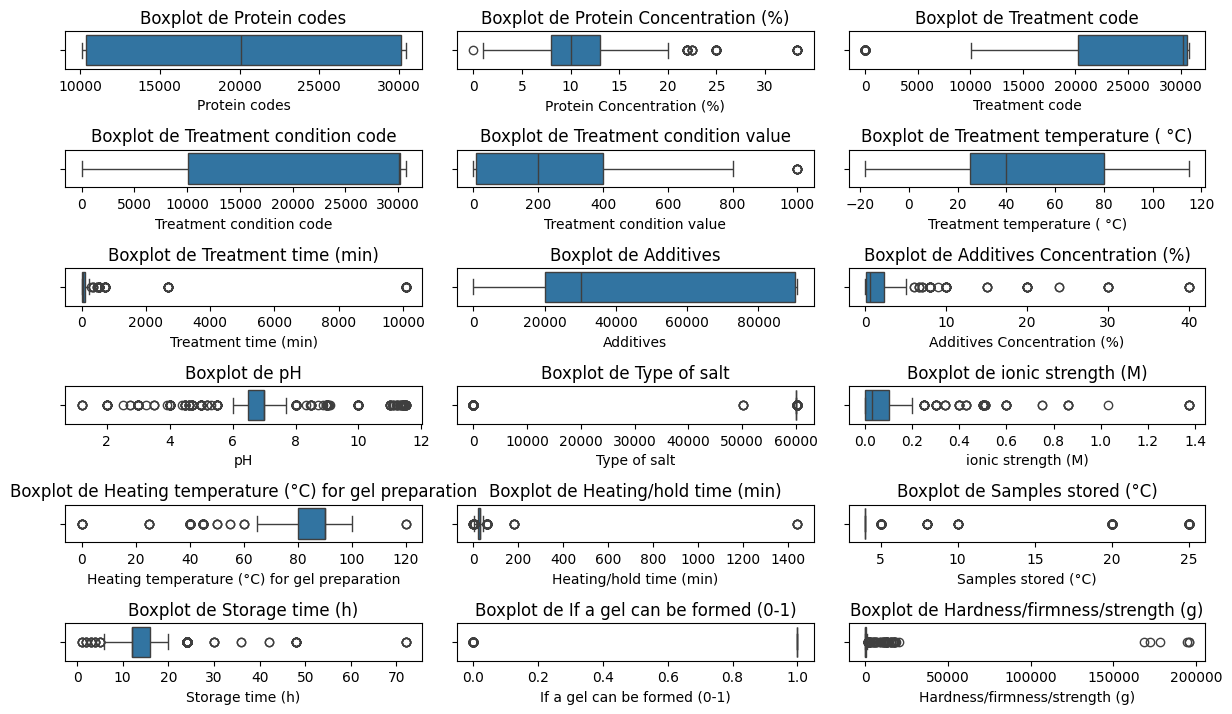

In [236]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_boxplots(df):
    """
    Affiche des boxplots pour toutes les colonnes numériques du DataFrame.
    
    Args:
    - df : DataFrame contenant les données à analyser.
    """
    # Sélectionner uniquement les colonnes numériques
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    # Initialiser la figure
    plt.figure(figsize=(12, 8))
    
    # Créer un boxplot pour chaque colonne numérique
    for i, col in enumerate(numeric_cols):
        plt.subplot(len(numeric_cols)//3 + 1, 3, i + 1)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot de {col}')
    
    plt.tight_layout()  # Ajuster l'espacement entre les subplots
    plt.show()

# Exemple d'utilisation :
plot_boxplots(df)


In [215]:
import numpy as np

def replace_outliers_with_mean(df):
    """
    Remplace les outliers dans chaque colonne numérique par la moyenne de cette colonne,
    sauf pour la colonne pH. 
    Pour "Hardness/firmness/strength (g)", toute valeur > 1500 est remplacée par la moyenne.
    
    Args:
    - df : DataFrame contenant les données à analyser.
    
    Returns:
    - DataFrame avec les outliers remplacés par la moyenne.
    """
    # Sélectionner uniquement les colonnes numériques sauf pH
    numeric_cols = df.select_dtypes(include=['number']).columns
    numeric_cols = [col for col in numeric_cols if col != 'pH']  # Exclure la colonne pH
    
    for col in numeric_cols:
        # Calculer les quartiles Q1 et Q3, ainsi que l'IQR (écart interquartile)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Définir les limites pour les outliers
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        
        # Calculer la moyenne de la colonne
        mean_value = df[col].mean()
        
        # Remplacer les outliers par la moyenne
        df[col] = df[col].apply(lambda x: mean_value if x < lower_limit or x > upper_limit or (col == "Hardness/firmness/strength (g)" and x > 1500) else x)
    
    return df

# Exemple d'utilisation :
df = replace_outliers_with_mean(df)


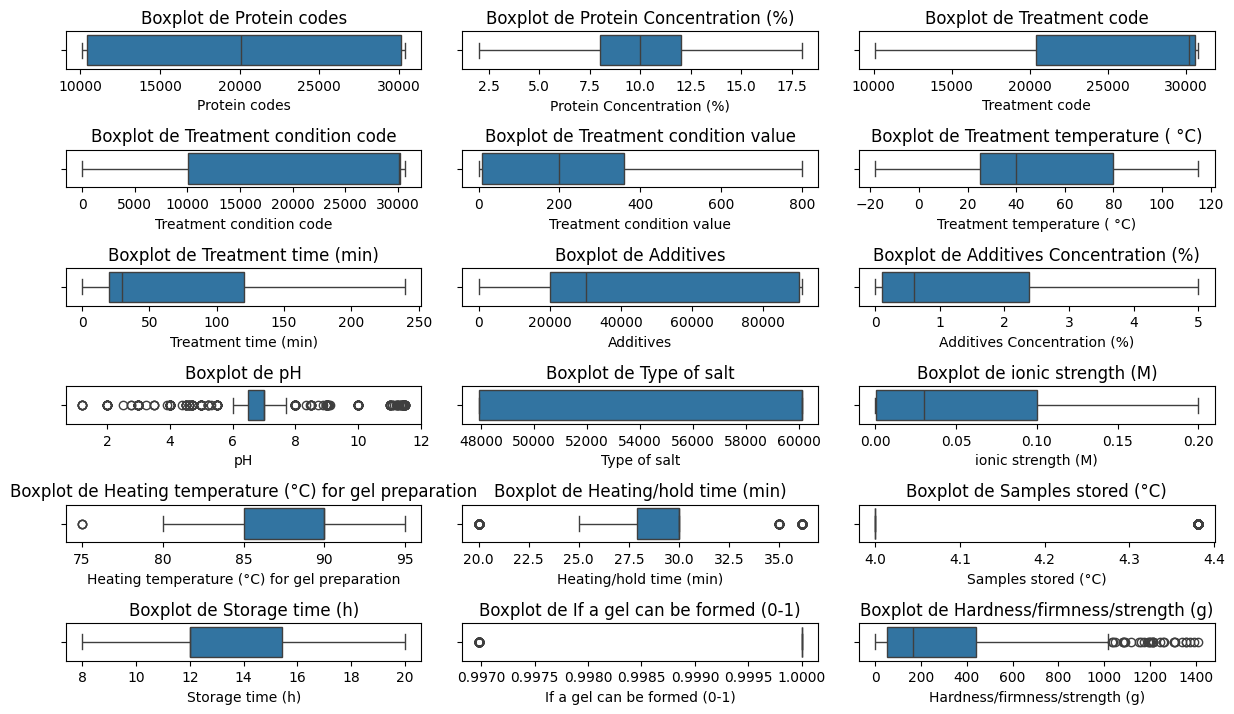

In [216]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_boxplots(df):
    """
    Affiche des boxplots pour toutes les colonnes numériques du DataFrame.
    
    Args:
    - df : DataFrame contenant les données à analyser.
    """
    # Sélectionner uniquement les colonnes numériques
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    # Initialiser la figure
    plt.figure(figsize=(12, 8))
    
    # Créer un boxplot pour chaque colonne numérique
    for i, col in enumerate(numeric_cols):
        plt.subplot(len(numeric_cols)//3 + 1, 3, i + 1)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot de {col}')
    
    plt.tight_layout()  # Ajuster l'espacement entre les subplots
    plt.show()

# Exemple d'utilisation :
plot_boxplots(df)


In [217]:
df.isna().sum()

Protein codes                                     0
Protein Concentration (%)                         0
Treatment code                                  393
Treatment condition code                        786
Treatment condition value                       828
Treatment temperature ( °C)                     652
Treatment time (min)                            523
Additives                                       388
Additives Concentration (%)                     411
pH                                              207
Type of salt                                    514
ionic strength (M)                              514
Heating temperature (°C) for gel preparation    169
Heating/hold time (min)                         169
Samples stored (°C)                             105
Storage time (h)                                229
If a gel can be formed (0-1)                      0
Hardness/firmness/strength (g)                    0
dtype: int64

## Imputation with KNN

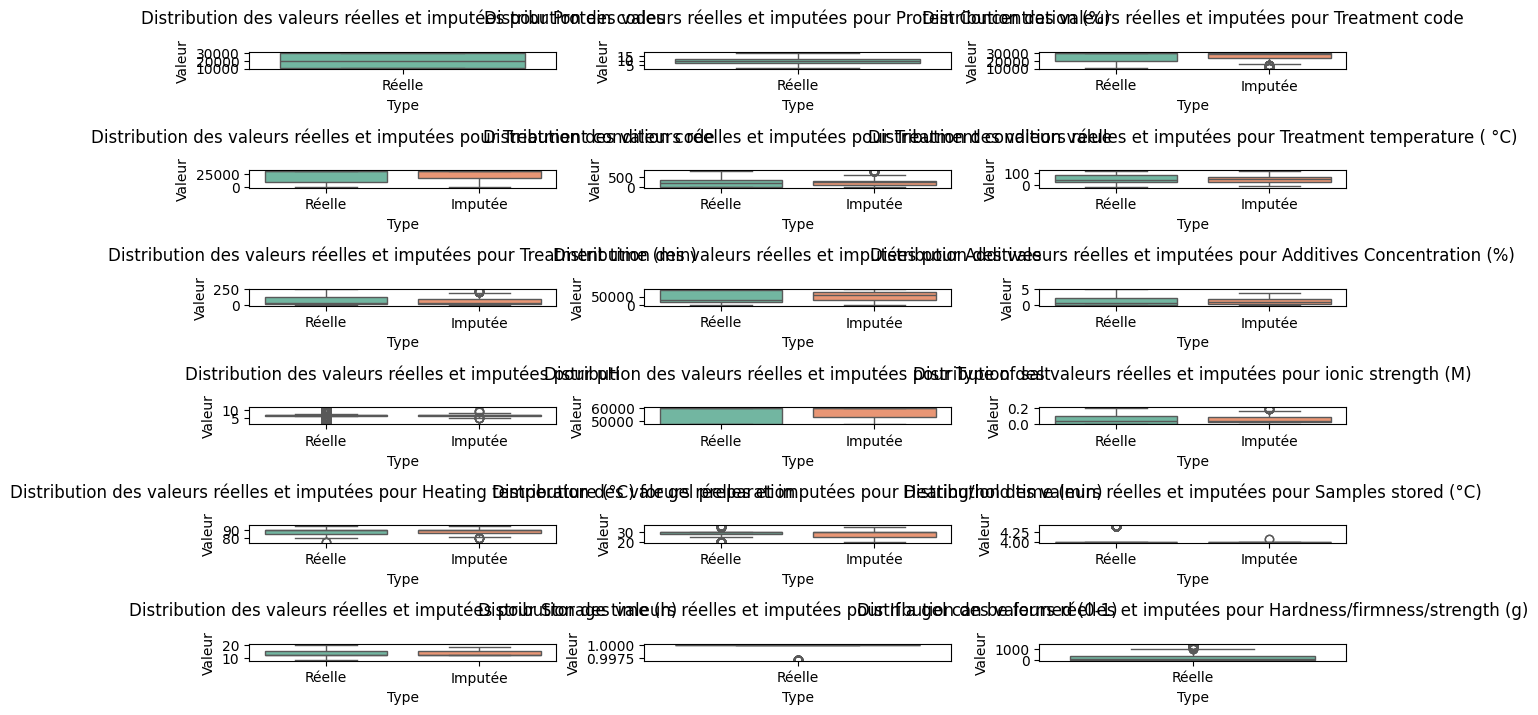

In [218]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

def knn_imputation_and_evaluation(df):
    """
    Effectue l'imputation KNN sur les colonnes numériques du DataFrame, puis compare
    les distributions des valeurs réelles et des valeurs imputées.
    
    Args:
    - df : DataFrame contenant les données à traiter.
    
    Retourne:
    - df_imputed : DataFrame avec les valeurs imputées.
    """
    # Sélectionner les colonnes numériques
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    # Créer un masque pour les valeurs manquantes
    nan_mask = df[numeric_cols].isna()
    
    # Appliquer l'imputation KNN
    imputer = KNNImputer(n_neighbors=5)
    df_imputed = df.copy()
    
    # Appliquer l'imputation sur les colonnes numériques uniquement
    df_imputed[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    
    # Comparer les distributions des valeurs réelles et des valeurs imputées
    # Visualisation avec des boxplots pour chaque colonne
    fig = plt.figure(figsize=(12, 8))
    
    for i, col in enumerate(numeric_cols):
        ax = fig.add_subplot(len(numeric_cols)//3 + 1, 3, i + 1)
        
        # Réinitialiser les index pour éviter les duplications après concaténation
        real_values = df[col].dropna().reset_index(drop=True)
        imputed_values = df_imputed.loc[nan_mask[col], col].reset_index(drop=True)
        
        # Combiner les valeurs réelles et imputées pour chaque colonne
        data = pd.DataFrame({
            'Valeur': pd.concat([real_values, imputed_values], ignore_index=True),
            'Type': ['Réelle'] * len(real_values) + ['Imputée'] * len(imputed_values)
        })
        
        # Plot des valeurs réelles et imputées avec un "hue" pour différencier
        sns.boxplot(x='Type', y='Valeur', data=data, palette="Set2", ax=ax)
        
        ax.set_title(f'Distribution des valeurs réelles et imputées pour {col}', fontsize=12, pad=20)
    
    # Ajuster les marges autour de l'ensemble de la figure pour les titres
    plt.subplots_adjust(hspace=0.6, top=0.9)  # Espacement entre les sous-figures et ajustement de la marge en haut
    plt.tight_layout()
    plt.show()
    
    return df_imputed

# Exemple d'utilisation :
df_imputed = knn_imputation_and_evaluation(df)


In [9]:
def save_missing_and_imputed(original_df, imputed_df):
    """
    Sauvegarde les lignes avec des valeurs manquantes et les lignes après imputation 
    dans deux fichiers Excel distincts.
    
    Args:
    - original_df : DataFrame avant imputation (avec valeurs manquantes).
    - imputed_df : DataFrame après imputation (valeurs imputées).
    """
    # Identifier les lignes avec des valeurs manquantes
    missing_rows = original_df[original_df.isna().any(axis=1)]
    
    # Sélectionner les mêmes lignes après imputation
    imputed_rows = imputed_df.loc[missing_rows.index]
    
    # Sauvegarder les deux DataFrames au format Excel
    missing_rows.to_excel("original_data_missingRow.xlsx", index=True)
    imputed_rows.to_excel("Imputation_data_ImputeRow.xlsx", index=True)
    
    print("✅ Les fichiers ont été sauvegardés :")
    print("- original_data_missingRow.xlsx (valeurs manquantes)")
    print("- Imputation_data_ImputeRow.xlsx (valeurs imputées)")
    
    return missing_rows, imputed_rows

# Exemple d'utilisation :
missing_rows, imputed_rows = save_missing_and_imputed(df, df_imputed)

✅ Les fichiers ont été sauvegardés :
- original_data_missingRow.xlsx (valeurs manquantes)
- Imputation_data_ImputeRow.xlsx (valeurs imputées)


In [219]:
df_imputed.isna().sum()

Protein codes                                   0
Protein Concentration (%)                       0
Treatment code                                  0
Treatment condition code                        0
Treatment condition value                       0
Treatment temperature ( °C)                     0
Treatment time (min)                            0
Additives                                       0
Additives Concentration (%)                     0
pH                                              0
Type of salt                                    0
ionic strength (M)                              0
Heating temperature (°C) for gel preparation    0
Heating/hold time (min)                         0
Samples stored (°C)                             0
Storage time (h)                                0
If a gel can be formed (0-1)                    0
Hardness/firmness/strength (g)                  0
dtype: int64

In [220]:
# Afficher les lignes dupliquées
duplicated_rows = df_imputed[df_imputed.duplicated()]

# Afficher le nombre de lignes dupliquées
print(f"Nombre de lignes dupliquées: {duplicated_rows.shape[0]}")

# Afficher les lignes dupliquées
duplicated_rows


Nombre de lignes dupliquées: 9


,Protein codes,Protein Concentration (%),Treatment code,Treatment condition code,Treatment condition value,Treatment temperature ( °C),Treatment time (min),Additives,Additives Concentration (%),pH,Type of salt,ionic strength (M),Heating temperature (°C) for gel preparation,Heating/hold time (min),Samples stored (°C),Storage time (h),If a gel can be formed (0-1),Hardness/firmness/strength (g)
369,30105.00,13.00,30601.00,30101.00,162.00,82.00,30.00,0.00,0.00,6.50,60101.00,0.10,90.00,30.00,4.38,12.00,1.00,440.92
402,30105.00,13.00,30601.00,30101.00,162.00,82.00,30.00,0.00,0.00,6.50,60103.00,0.10,90.00,30.00,4.38,12.00,1.00,440.92
403,30105.00,13.00,30305.00,24080.80,106.00,67.00,149.16,30203.00,4.00,6.50,60103.00,0.10,90.00,30.00,4.38,12.00,1.00,0.00
404,30105.00,13.00,30305.00,24080.80,106.00,67.00,149.16,30205.00,4.00,6.50,60103.00,0.10,90.00,30.00,4.38,12.00,1.00,0.00
657,12001.00,10.00,30201.00,30201.00,380.00,115.00,30.00,28168.20,0.48,7.00,47900.67,0.10,83.34,30.00,4.00,12.00,1.00,0.00
658,12001.00,10.00,30201.00,30201.00,380.00,115.00,30.00,28168.20,0.48,7.00,47900.67,0.10,83.34,30.00,4.00,12.00,1.00,0.00
659,12001.00,10.00,30201.00,30201.00,380.00,115.00,30.00,28168.20,0.48,7.00,47900.67,0.10,83.34,30.00,4.00,12.00,1.00,0.00
773,20119.00,10.00,30642.60,18120.60,300.00,34.00,42.00,56181.20,0.87,10.00,60101.00,0.10,90.00,27.89,4.00,15.44,1.00,298.77
780,10301.00,15.00,20303.00,20101.00,8.70,91.00,15.00,90507.00,0.80,6.93,60101.00,0.10,95.00,30.00,4.00,13.37,1.00,82.78


In [221]:
df_imputed.drop_duplicates(inplace=True)

## Univariate analysis on (Hardness/firmness/strength)

In [19]:
df_imputed["Hardness/firmness/strength (g)"].unique()

array([1.31910000e+02, 1.55910000e+02, 1.51140000e+02, 1.44840000e+02,
       9.57100000e+01, 1.07430000e+02, 1.09450000e+02, 1.18660000e+02,
       2.94500000e+01, 4.63400000e+01, 5.83800000e+01, 9.76500000e+01,
       6.06480000e+02, 0.00000000e+00, 4.61780000e+02, 5.45950000e+02,
       6.22050000e+02, 1.91941943e+03, 1.20244000e+03, 1.25950000e+02,
       2.51820000e+02, 3.19560000e+02, 1.17266000e+03, 1.09108000e+03,
       1.35620000e+03, 7.76000000e+01, 9.54400000e+01, 1.42760000e+02,
       1.83550000e+02, 6.00600000e+01, 7.24000000e+01, 4.74160000e+02,
       6.81160000e+02, 7.60700000e+02, 1.11960000e+02, 4.26230000e+02,
       6.57710000e+02, 1.08088000e+03, 5.14900000e+01, 5.38400000e+02,
       8.54510000e+02, 1.01664000e+03, 1.37558000e+03, 1.69270000e+02,
       1.30929000e+03, 5.30200000e+01, 6.32200000e+01, 7.54600000e+01,
       7.95400000e+01, 8.05600000e+01, 9.78900000e+01, 1.25420000e+02,
       1.57030000e+02, 1.19300000e+02, 2.07000000e+02, 2.59000000e+02,
      

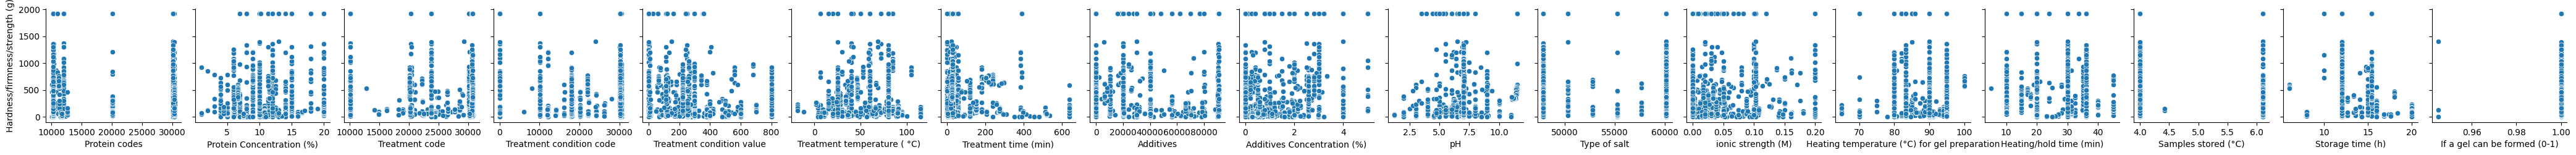

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Définir la variable pour l'axe Y
y_var = "Hardness/firmness/strength (g)"  # Remplace par le nom de ta colonne cible

# Sélectionner toutes les autres colonnes sauf y_var pour l'axe X
x_vars = [col for col in df.columns if col != y_var]

# Créer le pairplot en mode horizontal
sns.pairplot(df_imputed, x_vars=x_vars, y_vars=[y_var], diag_kind="kde", height=2.5)

# Afficher le graphique
plt.show()


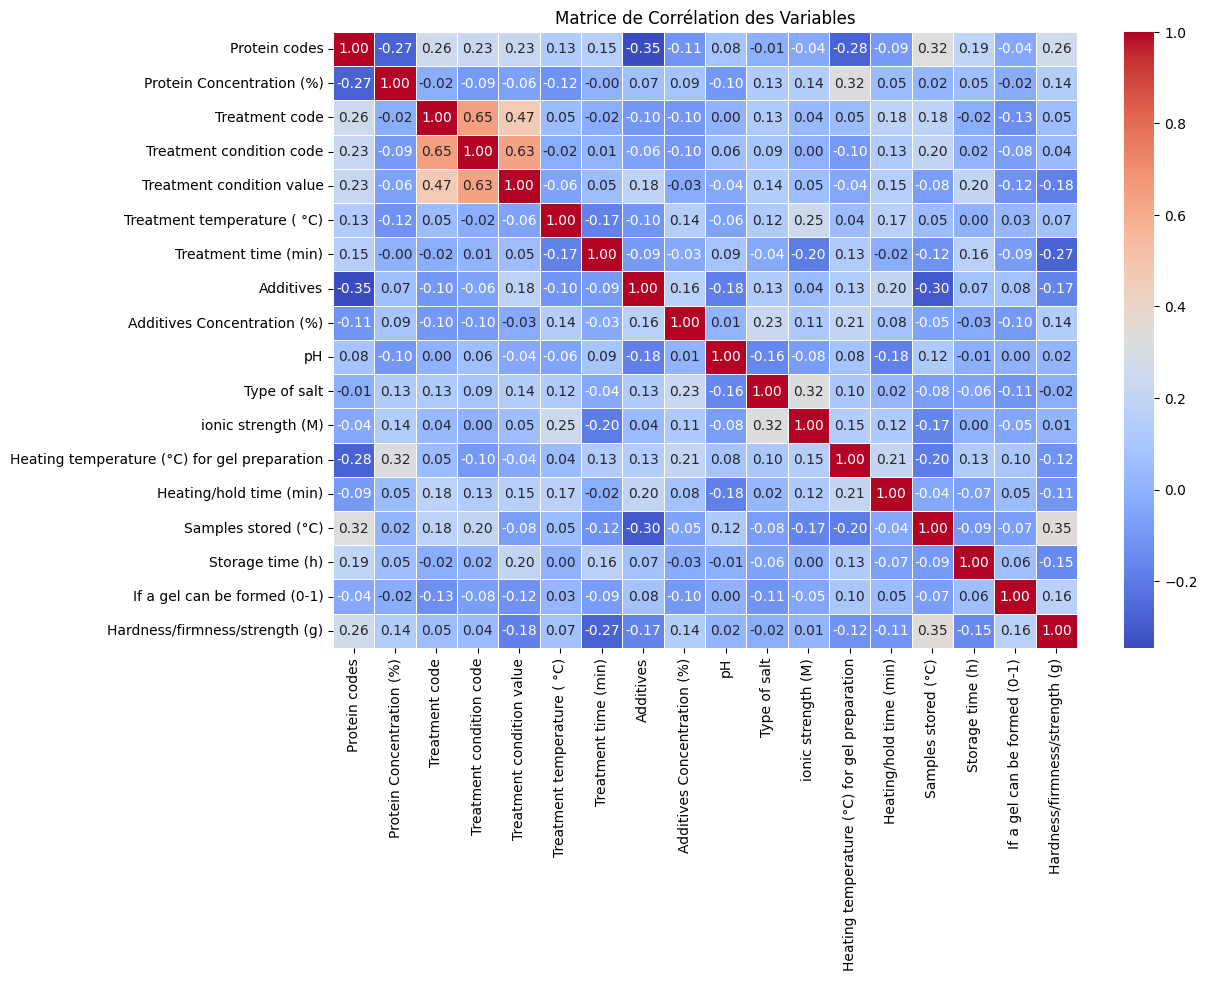

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Définition de la figure
plt.figure(figsize=(12, 8))

# Heatmap avec annotations et une palette de couleurs contrastée
sns.heatmap(df_imputed.select_dtypes(include="number").corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Ajout d'un titre
plt.title("Matrice de Corrélation des Variables")

# Affichage du graphique
plt.show()

**Correlation of Pearson**

In [222]:
from scipy.stats import pearsonr

corr, p_value = pearsonr(df_imputed["Hardness/firmness/strength (g)"], df_imputed["Samples stored (°C)"])
print(f"Corrélation de Pearson : {corr:.2f}, p-value : {p_value:.5f}")

Corrélation de Pearson : 0.17, p-value : 0.00000


<Axes: >

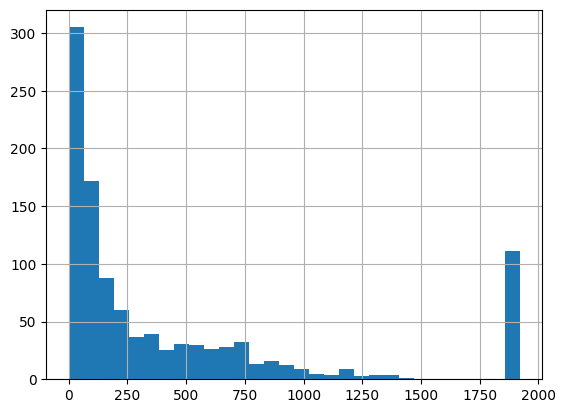

In [16]:
df_imputed["Hardness/firmness/strength (g)"].hist(bins=30)

## 2 - Train models

In [224]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# X et y
X = df_imputed.drop('Hardness/firmness/strength (g)', axis=1)
y = df_imputed['Hardness/firmness/strength (g)']


In [225]:
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

# 5. Séparation des données en ensembles d'entraînement et de test (80% Train et 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Initialisation des modèles
models = {
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3, random_state=42),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),
    "LinearSVR": LinearSVR(random_state=42),
    "KNeighbors": KNeighborsRegressor(n_neighbors=5),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, random_state=42, verbose=0),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, random_state=42)
}

In [226]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 9. Entraînement et évaluation des modèles
results = []

# Boucle sur les modèles
for name, model in models.items():
    # Création d'un pipeline avec le modèle
    pipeline = Pipeline([("model", model)])
    
    # Entraînement
    pipeline.fit(X_train, y_train)
    
    # Prédictions
    y_pred = pipeline.predict(X_test)
    
    # Calcul des métriques
    metrics = {
        "R²": round(r2_score(y_test, y_pred) * 100, 2),  # Conversion en pourcentage et arrondi
        "MAE": round(mean_absolute_error(y_test, y_pred), 2),
        "MSE": round(mean_squared_error(y_test, y_pred), 2),
        "RMSE": round(mean_squared_error(y_test, y_pred, squared=False), 2)  # Ajout de la RMSE
    }
    
    # Stockage des résultats dans une liste
    results.append({"Modèle": name, **metrics})

# 10. Affichage des résultats sous forme de DataFrame
df_results = pd.DataFrame(results).sort_values(by="R²", ascending=False)

# Affichage du DataFrame sans notation scientifique
pd.set_option("display.float_format", "{:.2f}".format)

# Affichage des résultats
df_results


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 747
[LightGBM] [Info] Number of data points in the train set: 851, number of used features: 17
[LightGBM] [Info] Start training from score 288.936010
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,Modèle,R²,MAE,MSE,RMSE
7,CatBoost,85.96,62.05,10991.16,104.84
8,XGBoost,85.42,58.37,11413.07,106.83
9,LightGBM,84.00,68.31,12530.07,111.94
6,RandomForest,83.58,63.32,12854.85,113.38
2,GradientBoosting,73.85,90.23,20477.05,143.10
5,KNeighbors,73.80,85.63,20517.14,143.24
3,AdaBoost,26.76,198.36,57346.42,239.47
1,ElasticNet,18.84,184.89,63549.93,252.09
4,LinearSVR,-37.68,265.30,107803.27,328.33
0,SGDRegressor,-52085790937009041106492923366604800.00,6276929365853556736.00,40783417177989827570747774540045090816.00,6386189566399499264.00


R² Score: 0.9546
Mean Absolute Error (MAE): 74.4666
Root Mean Squared Error (RMSE): 136.5962

## First training of Random Forest with outlier data

In [24]:
print(f"Taille de X_test : {X_test.shape}")
print(f"Taille de y_test : {y_test.shape}")

Taille de X_test : (213, 17)
Taille de y_test : (213,)


In [227]:
from sklearn.impute import SimpleImputer
from catboost import CatBoostRegressor

# Créer et entraîner le modèle CatBoost avec les données transformées
Xg_boost_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, random_state=42, verbose=0)
Xg_boost_model.fit(X_train, y_train)


R² Score: 0.8596
Mean Absolute Error (MAE): 62.0527
Root Mean Squared Error (RMSE): 104.8387


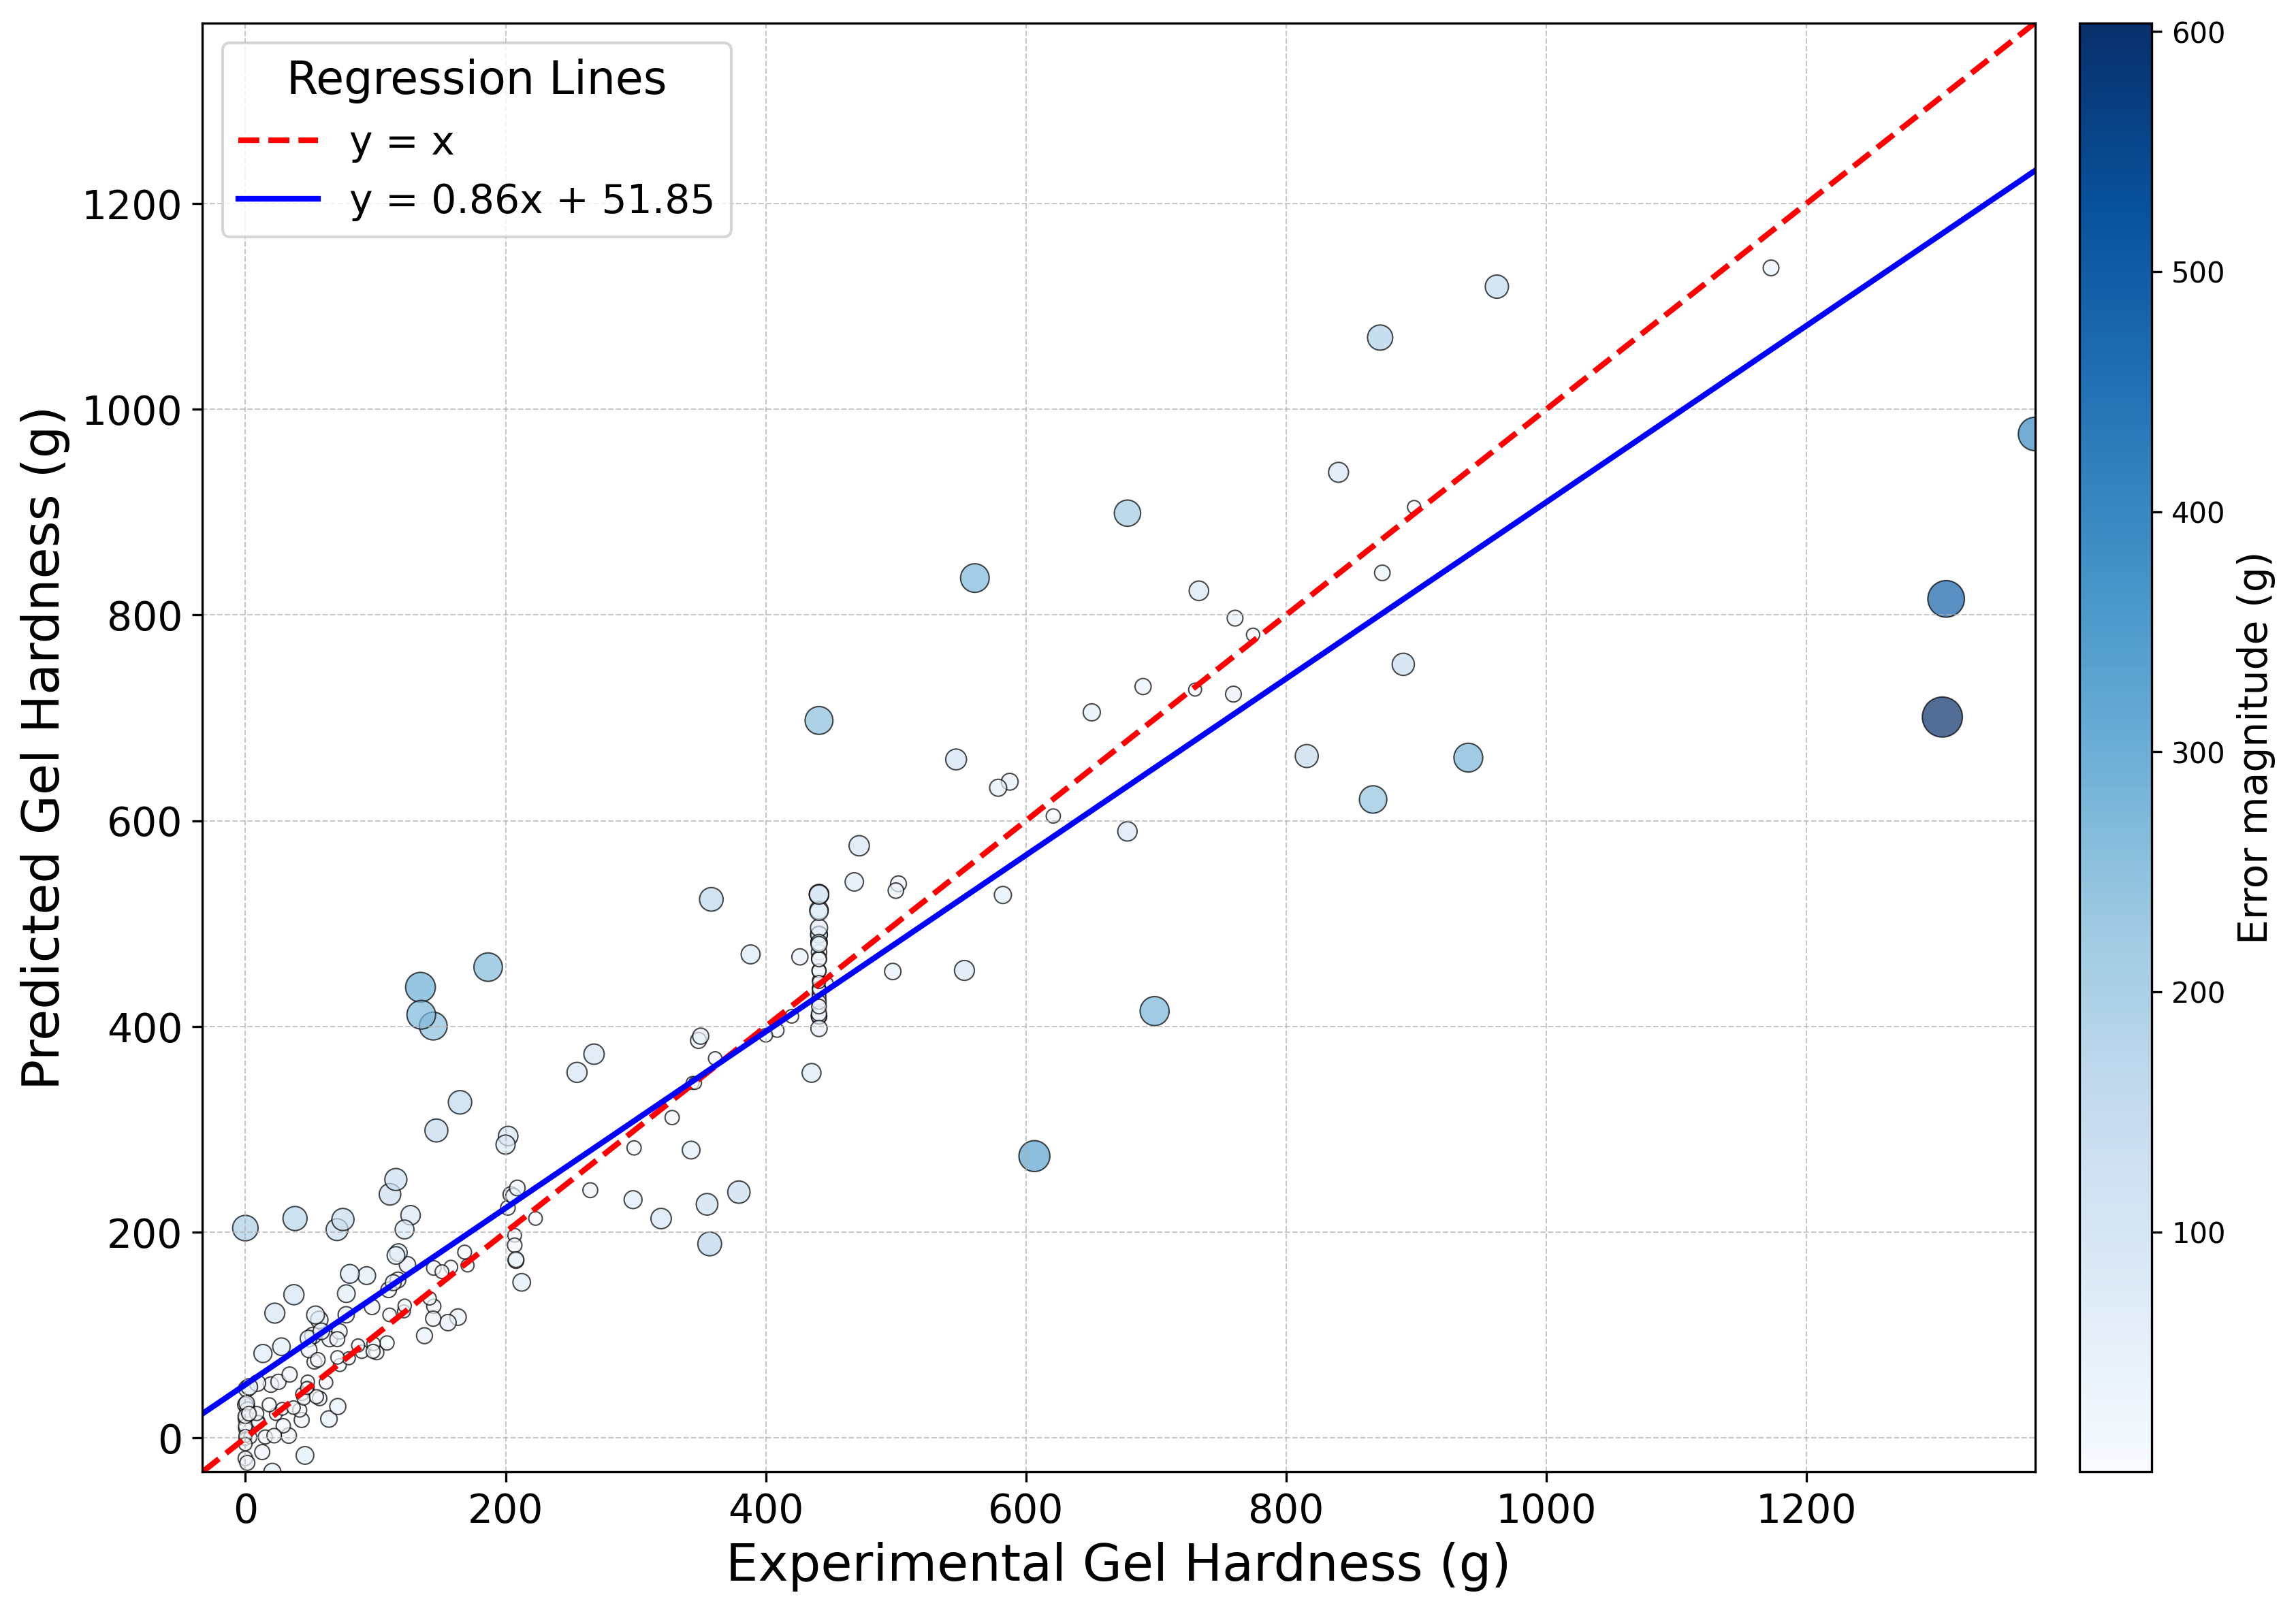

In [228]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prédictions du modèle sur les données de test
y_pred = Xg_boost_model.predict(X_test)

# Calcul des métriques de performance
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Affichage des métriques
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Tracer le graphique optimisé
plt.figure(figsize=(12, 8), dpi=300)

# Scatter plot avec la palette de bleus
scatter = sns.scatterplot(
    x=y_test,
    y=y_pred,
    hue=np.abs(y_test - y_pred),  # Erreur absolue en couleur
    palette='Blues',  # Nuances de bleu
    size=np.abs(y_test - y_pred),  # Taille en fonction de l'erreur
    sizes=(20, 200),  # Taille minimale et maximale
    alpha=0.7,  # Transparence pour éviter le chevauchement
    edgecolor='k',  # Bordure pour améliorer la lisibilité
    linewidth=0.5,
    legend=False  # Supprime l'échelle des couleurs de la légende
)

# Ligne idéale (y = x) en pointillés rouges
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label="y = x")

# Ajouter la régression linéaire (y = ax + b)
a, b = np.polyfit(y_test, y_pred, 1)  # Estimation des coefficients de la régression linéaire
y_reg = a * np.array([min_val, max_val]) + b  # Calcul des valeurs y pour la courbe
plt.plot([min_val, max_val], y_reg, color='blue', linestyle='-', linewidth=2, label=f"y = {a:.2f}x + {b:.2f}")

# Annoter l'erreur maximale (avec un fond blanc pour lisibilité)
'''max_error_index = np.argmax(np.abs(y_test - y_pred))
plt.annotate(
    f"Max Error: {y_test.iloc[max_error_index]} → {y_pred[max_error_index]:.2f}",
    (y_test.iloc[max_error_index], y_pred[max_error_index]),
    textcoords="offset points",
    xytext=(30, 30),  # Décalage pour éviter la superposition sur les points
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),  # Fond blanc
    arrowprops=dict(arrowstyle="->", color='black', lw=1.5)
)'''

# Ajustements des axes
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Ajouter le titre et les labels
plt.xlabel("Experimental Gel Hardness (g)", fontsize=18)
plt.ylabel("Predicted Gel Hardness (g)", fontsize=18)
#plt.title(f"Comparison of model predictions (R² = {r2:.4f})", fontsize=20)

# Ajuster la taille des ticks (graduations des axes)
plt.tick_params(axis='both', labelsize=14)

# Légende avec uniquement les deux droites (idéal + régression)
plt.legend(fontsize=14, title="Regression Lines", title_fontsize=16, loc='upper left')

# Ajouter une colorbar pour une meilleure lisibilité des erreurs
norm = plt.Normalize(np.abs(y_test - y_pred).min(), np.abs(y_test - y_pred).max())
sm = plt.cm.ScalarMappable(cmap='Blues', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.02)
cbar.set_label("Error magnitude (g)", fontsize=14)

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)  # Grille plus discrète
plt.tight_layout()
plt.show()


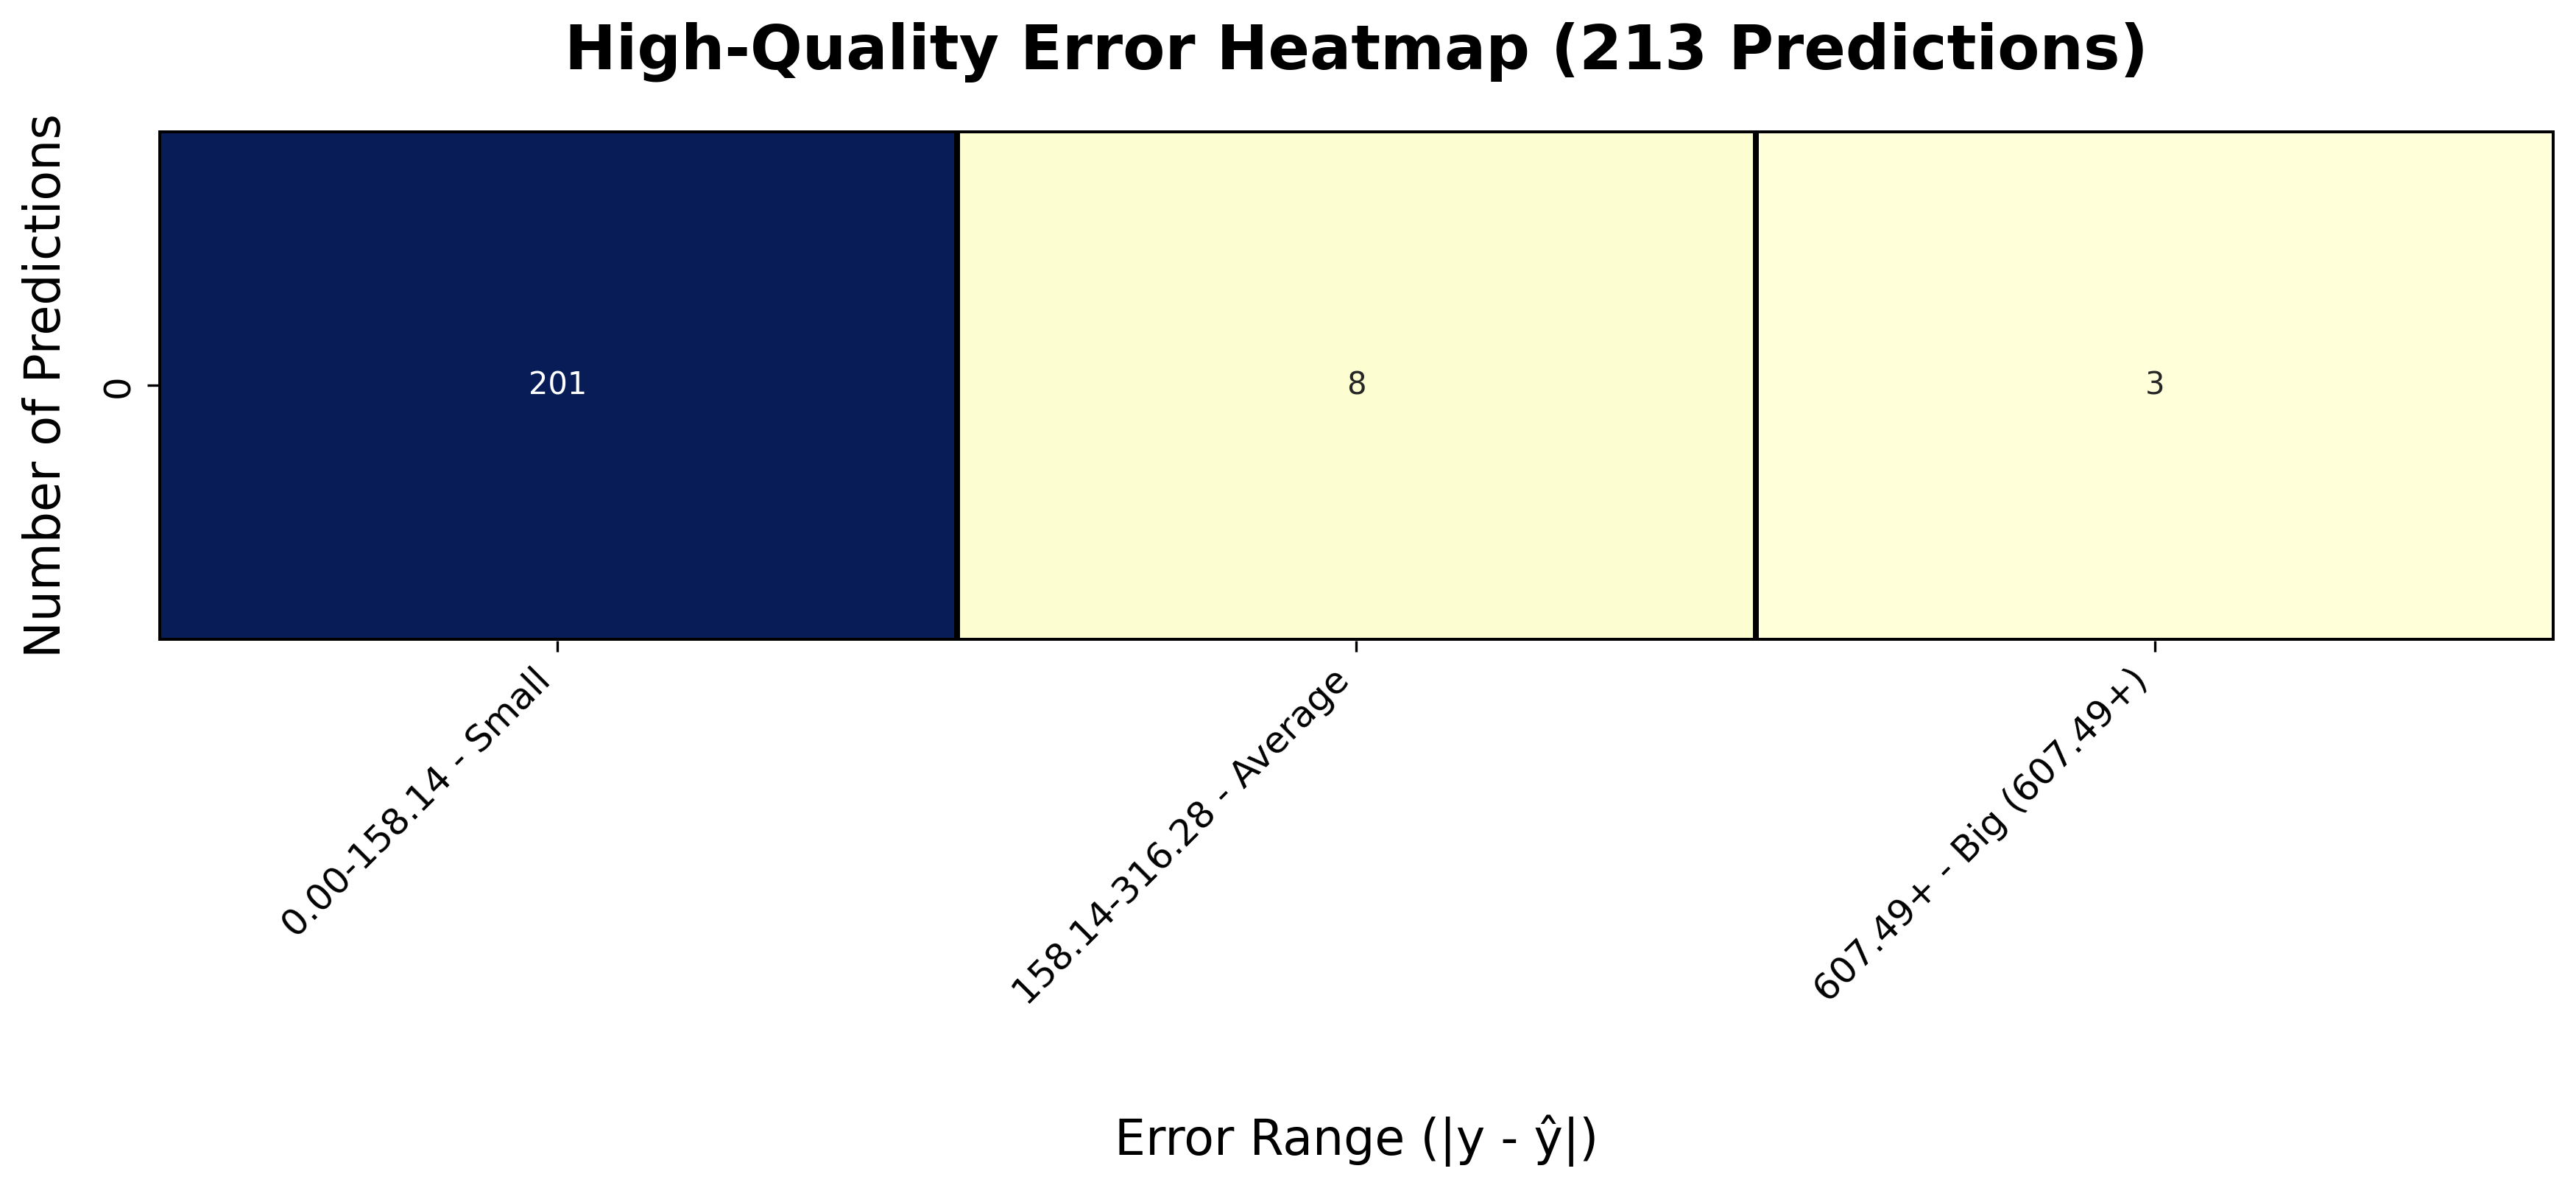

In [206]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def error_matrix_heatmap(y_true, y_pred, num_bins=5, big_threshold=None, save_path=None):
    """
    Crée une heatmap de haute qualité représentant la matrice d'écart entre les valeurs réelles et prédites pour un modèle de régression.
    
    Args:
    - y_true : Valeurs réelles
    - y_pred : Valeurs prédites
    - num_bins : Nombre d'intervalles pour les erreurs
    - big_threshold : Seuil à partir duquel l'intervalle "Big" est modifié (affiche 'x+')
    - save_path : Chemin pour enregistrer le graphique (facultatif)
    
    Retourne :
    - Heatmap de la matrice d'écart.
    """
    # Calcul de l'erreur absolue
    errors = np.abs(y_true - y_pred)
    
    # Définir les intervalles d'erreur dynamiquement en fonction des données
    max_error = errors.max()
    bins = np.linspace(0, max_error, num_bins + 1)
    
    # Créer des étiquettes dynamiques pour les intervalles
    labels = [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins) - 1)]
    size_labels = ['Small', 'Average', 'Big']
    
    # Si un seuil "Big" est défini, ajuster le dernier intervalle
    if big_threshold is not None:
        labels[-1] = f"{big_threshold}+"
        size_labels[-1] = f"Big ({big_threshold}+)"

    # Catégoriser les erreurs en fonction des intervalles
    error_categories = pd.cut(errors, bins=bins, labels=labels, right=False)

    # Compter les occurrences de chaque catégorie d'erreur
    error_counts = error_categories.value_counts().reindex(labels, fill_value=0)

    # Préparer les données pour la heatmap
    heatmap_data = pd.DataFrame(error_counts.values.reshape(1, -1), columns=error_counts.index)

    # Créer la heatmap avec une résolution élevée et des ajustements esthétiques
    plt.figure(figsize=(14, 3), dpi=300)  # Taille augmentée et meilleure résolution
    sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu", cbar=False, linewidths=1.5, linecolor='black')

    # Ajouter les labels et le titre avec des polices améliorées
    plt.title(f"High-Quality Error Heatmap ({y_pred.shape[0]} Predictions)", fontsize=20, pad=20, fontweight='bold')
    plt.xlabel("\nError Range (|y - ŷ|)", fontsize=16, labelpad=15)
    plt.ylabel("Number of Predictions", fontsize=16, labelpad=10)

    # Ajuster les ticks avec des labels clairs
    plt.xticks(ticks=np.arange(len(labels)) + 0.5,
               labels=[f"{label} - {size}" for label, size in zip(labels, size_labels)],
               rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    # Ajuster les marges pour éviter la coupure des textes
    plt.tight_layout()

    # Enregistrer le graphique en haute qualité si un chemin est fourni
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

# Exemple d'utilisation avec un seuil et un enregistrement du graphique
error_matrix_heatmap(y_test, y_pred, num_bins=3, big_threshold=607.49, save_path="error_heatmap_hd.png")


## CROSS VALIDATION ON 5-KFOLD

In [229]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# Définir la validation croisée (5 folds)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Appliquer la validation croisée avec R² comme métrique
scores = cross_val_score(Xg_boost_model, X_train, y_train, cv=cv, scoring='r2')

# Afficher les résultats
print(f"Scores de chaque fold: {scores}")
print(f"R² moyen: {np.mean(scores):.4f}")
print(f"Écart-type des scores: {np.std(scores):.4f}")


Scores de chaque fold: [0.84563711 0.83214042 0.74875146 0.81630106 0.76419408]
R² moyen: 0.8014
Écart-type des scores: 0.0382


In [230]:
# 2. Créer une copie de X_test pour éviter toute modification non voulue
X_test_copy = X_test.copy()

# 3. Ajouter les colonnes de labels réels et prédits
X_test_copy['True label'] = y_test
X_test_copy['Predict Label'] = y_pred

# 4. Définir la tolérance de 30% pour les prédictions correctes
tol = 0.7

# 5. Filtrer les prédictions correctes en fonction de la tolérance
correct_predictions = X_test_copy[np.abs(X_test_copy['True label'] - X_test_copy['Predict Label']) < tol]

# 6. Afficher un échantillon de prédictions correctes (maximum de 11 échantillons)
sample_size = min(11, len(correct_predictions))
correct_predictions.sample(sample_size)


,Protein codes,Protein Concentration (%),Treatment code,Treatment condition code,Treatment condition value,Treatment temperature ( °C),Treatment time (min),Additives,Additives Concentration (%),pH,Type of salt,ionic strength (M),Heating temperature (°C) for gel preparation,Heating/hold time (min),Samples stored (°C),Storage time (h),If a gel can be formed (0-1),True label,Predict Label
494,30108.00,8.00,20403.00,20101.00,11.30,65.00,132.89,48228.40,1.93,8.00,60104.20,0.00,95.00,30.00,4.00,13.60,1.00,28.35,28.33
922,30105.00,10.00,30601.00,30602.00,800.00,80.00,30.00,6120.60,1.54,7.00,60101.00,0.20,85.34,32.45,4.00,12.00,1.00,345.69,345.04
113,10301.00,5.00,30601.00,30605.00,255.02,95.00,90.00,20303.00,0.25,1.20,55222.87,0.03,83.34,36.13,4.00,12.00,1.00,23.45,23.25


## Check the homoscedasticity of the residuals and the distribution of the residuals

✔ If the residuals (errors between prediction and true value) are randomly distributed around zero (without any obvious structure), this means that the homoscedasticity assumption is met.

❌ If a particular shape appears (e.g. open or closed cone), this indicates heteroscedasticity, which can distort predictions and require data transformation.

✔ If the residuals have a bell-shaped (Gaussian) distribution, then the normality hypothesis is respected.

❌ If the residuals are asymmetric or have extreme values ​​(thick tails), this may indicate the presence of outliers or the need for a data transformation (e.g. logarithmic).

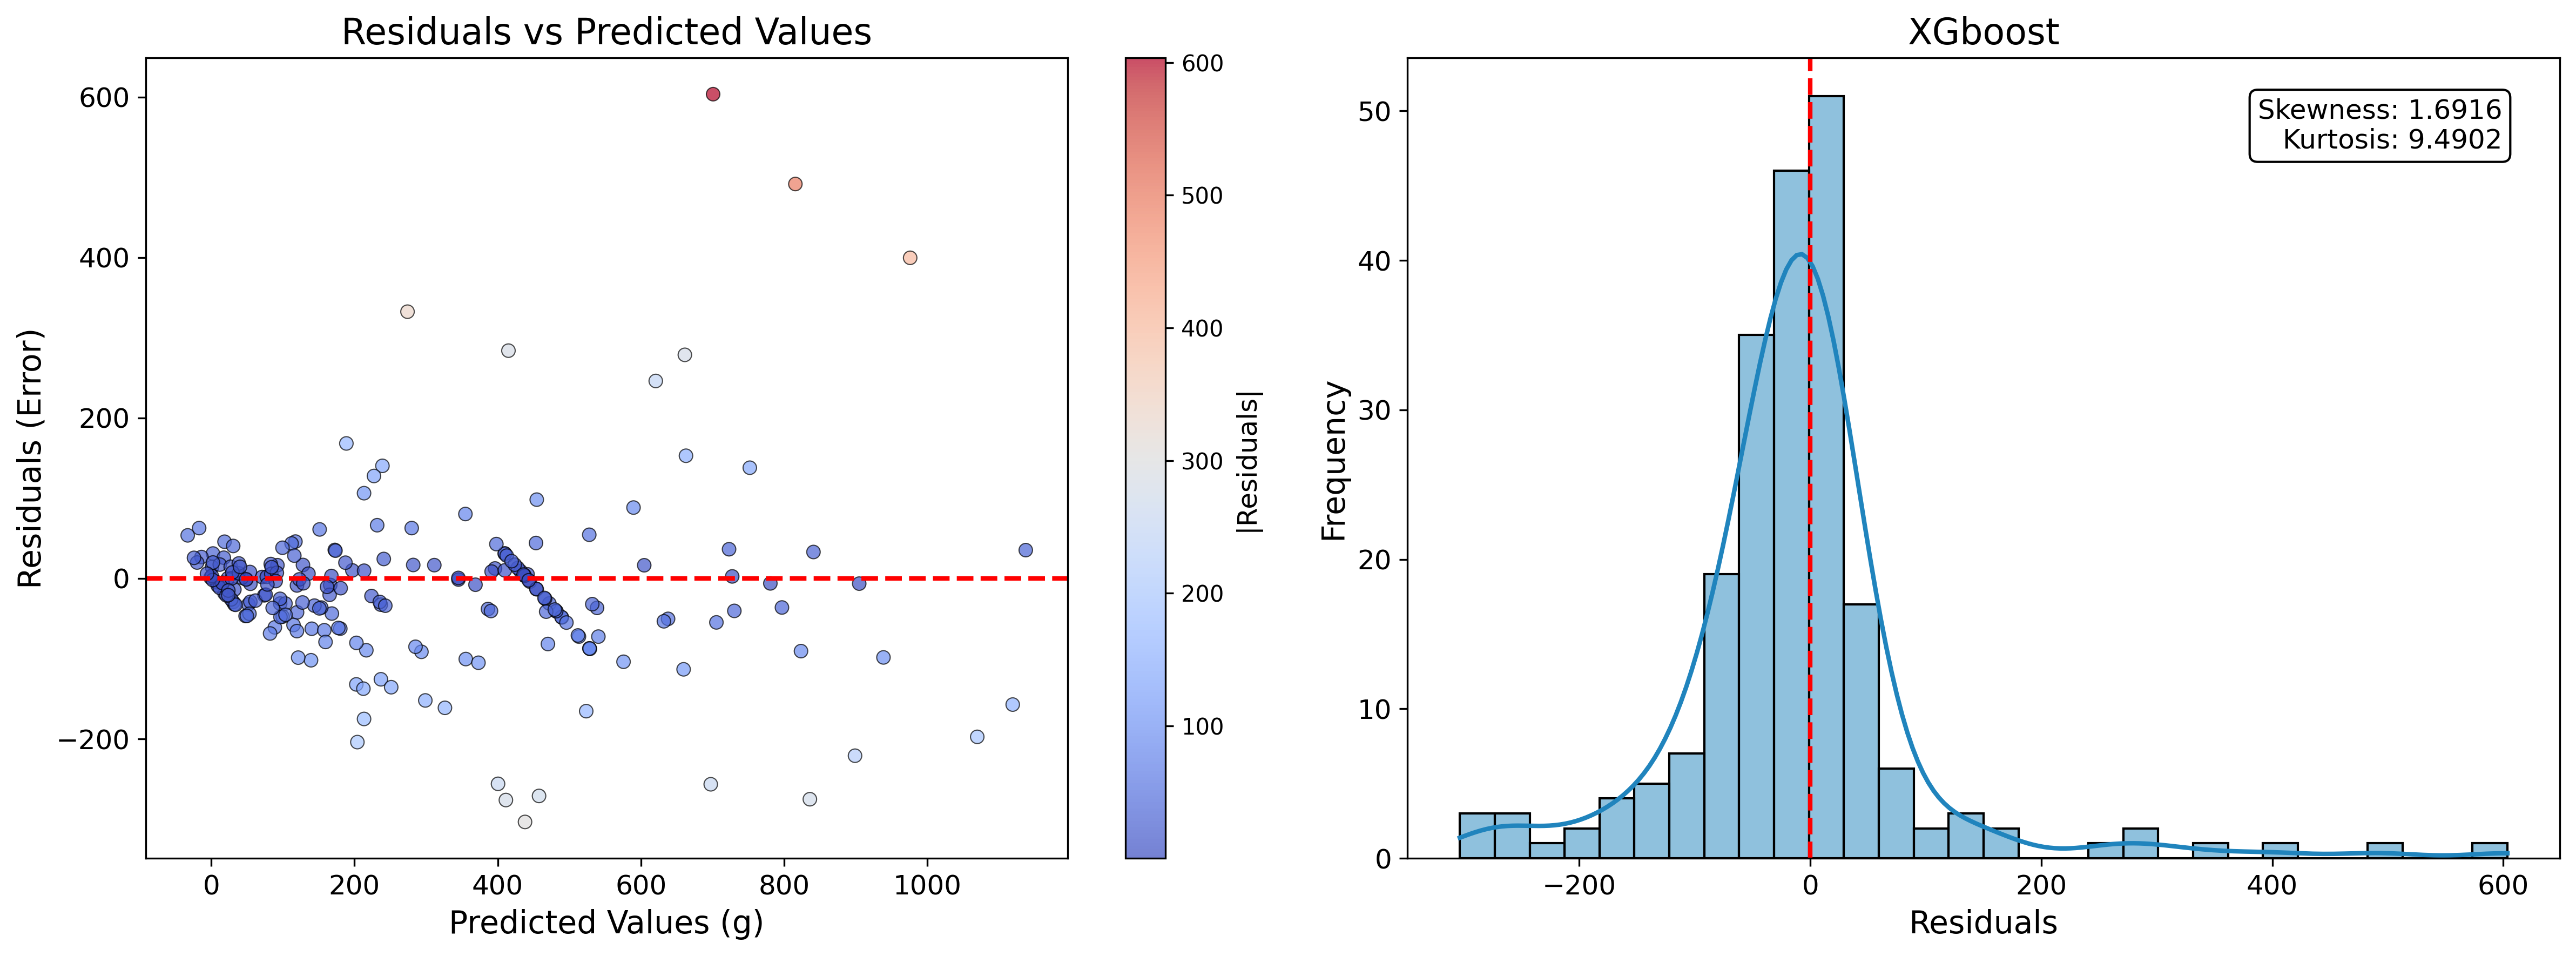

Skewness : 1.6916
Kurtosis : 9.4902


In [231]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Calculation of residuals
residuals = y_test - y_pred

# Creating a single figure with 2 sub-graphs
fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=300)

# 1st Graph: Plot of residuals vs predicted values
scatter = axes[0].scatter(y_pred, residuals, c=np.abs(residuals), cmap="coolwarm", alpha=0.7, edgecolor="k", linewidth=0.5)
axes[0].axhline(y=0, color="red", linestyle="dashed", linewidth=2)  # Ligne horizontale à 0
axes[0].set_xlabel("Predicted Values (g)", fontsize=14)
axes[0].set_ylabel("Residuals (Error)", fontsize=14)
axes[0].set_title("Residuals vs Predicted Values", fontsize=16)
axes[0].tick_params(axis='both', labelsize=12)

# Adding a colorbar for better interpretation
cbar = fig.colorbar(scatter, ax=axes[0])
cbar.set_label("|Residuals|", fontsize=12)

# 2nd Graph: Histogram of residuals
sns.histplot(residuals, bins=30, kde=True, color="#2084bd", edgecolor="black", ax=axes[1], line_kws={'linewidth': 2})
axes[1].axvline(x=0, color='red', linestyle='dashed', linewidth=2)  # Ligne centrale
axes[1].set_title("XGboost", fontsize=16)
axes[1].set_xlabel("Residuals", fontsize=14)
axes[1].set_ylabel("Frequency", fontsize=14)
axes[1].tick_params(axis='both', labelsize=12)

# Adding skewness and kurtosis as annotations
axes[1].annotate(f"Skewness: {stats.skew(residuals):.4f}\nKurtosis: {stats.kurtosis(residuals):.4f}", 
                 xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top', fontsize=12, bbox=dict(boxstyle="round", fc="white", ec="black"))

# Display
plt.tight_layout()
plt.show()

print(f"Skewness : {stats.skew(residuals):.4f}")
print(f"Kurtosis : {stats.kurtosis(residuals):.4f}")


In [232]:
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

# Ajouter une constante aux variables explicatives
X = sm.add_constant(X_test)

# Exécuter le test de Breusch-Pagan
test = het_breuschpagan(residuals, X)
p_value = test[1]

# Affichage des résultats avec interprétation
print(f"Breusch-Pagan p-value: {p_value:.4f}")

if p_value < 0.05:
    print("🔴 Hétéroscédasticité détectée : La variance des résidus n'est pas constante.")
    print("📌 Il peut être nécessaire d'appliquer une transformation des données ou d'utiliser une régression robuste.")
else:
    print("🟢 Homoscédasticité confirmée : La variance des résidus est constante.")
    print("✅ Aucune correction nécessaire pour l’hétéroscédasticité.")


Breusch-Pagan p-value: 0.0411
🔴 Hétéroscédasticité détectée : La variance des résidus n'est pas constante.
📌 Il peut être nécessaire d'appliquer une transformation des données ou d'utiliser une régression robuste.


In [105]:
from scipy.stats import shapiro

stat, p_value = shapiro(residuals)
print(f"Shapiro-Wilk test p-value: {p_value:.4f}")

if p_value > 0.05:
    print("The residuals follow a normal distribution (normality hypothesis accepted).")
else:
    print("The residuals do not follow a normal distribution (normality hypothesis rejected).")


Shapiro-Wilk test p-value: 0.0000
The residuals do not follow a normal distribution (normality hypothesis rejected).


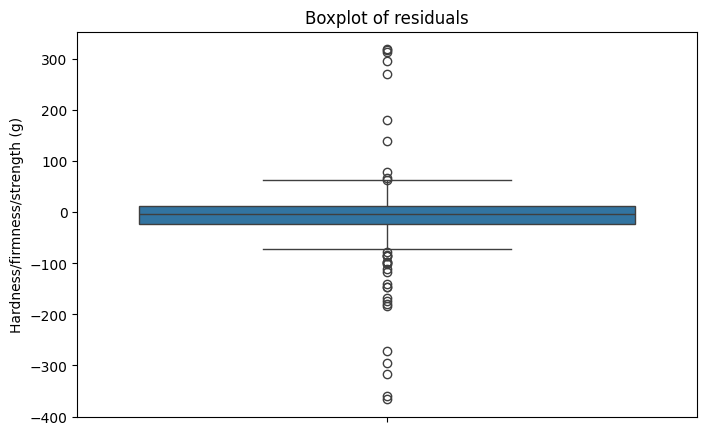

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(y=residuals)
plt.title("Boxplot of residuals")
plt.show()


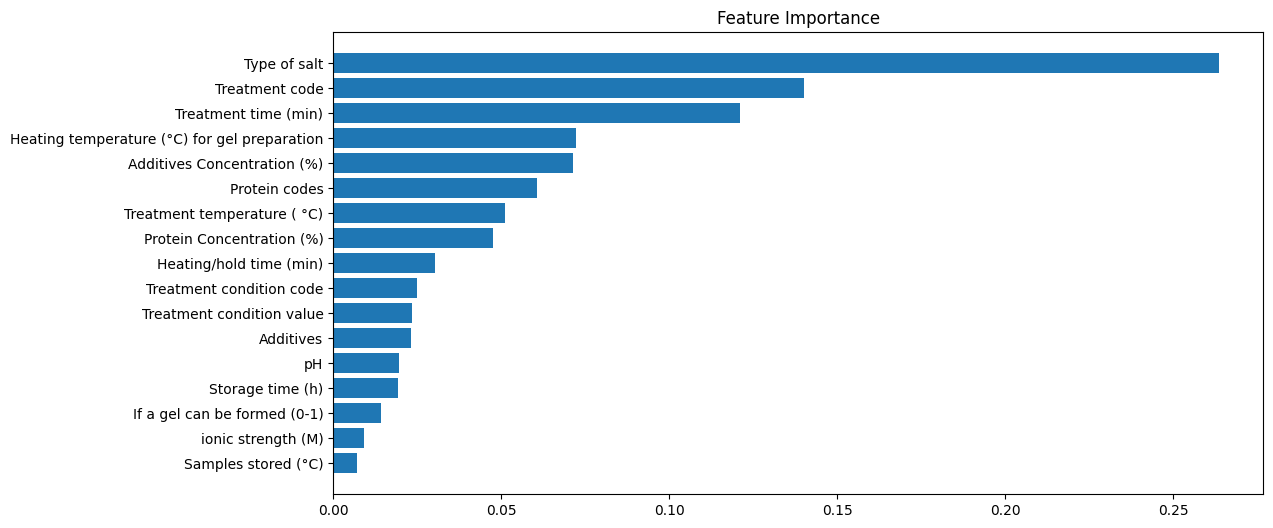

In [107]:
from matplotlib import pyplot as plt

feature_importance = Xg_boost_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

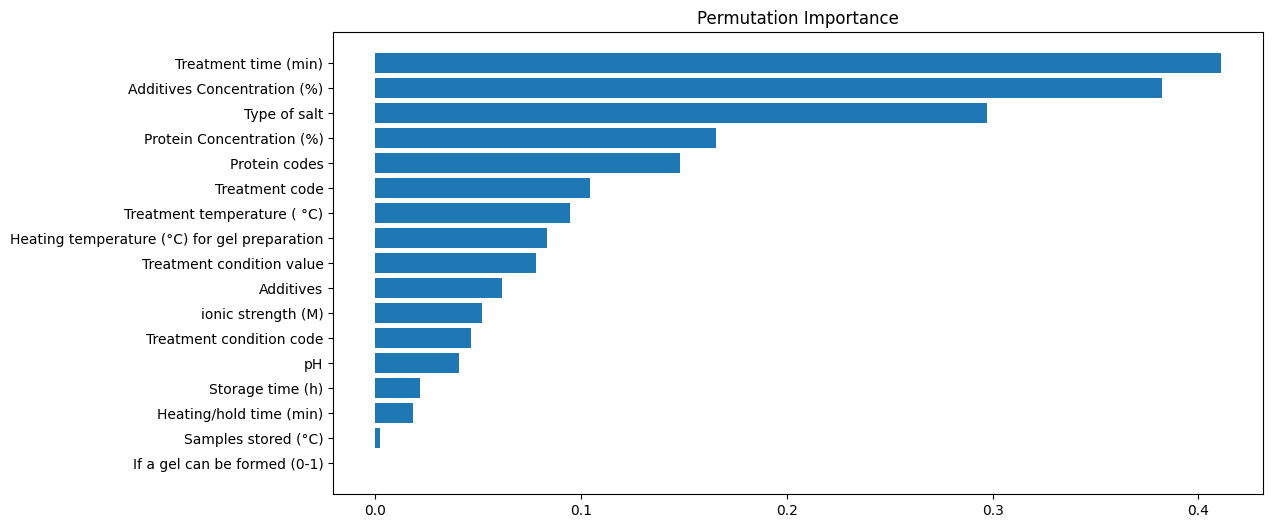

In [108]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(Xg_boost_model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')
plt.show()

### Explanation using SHAP values

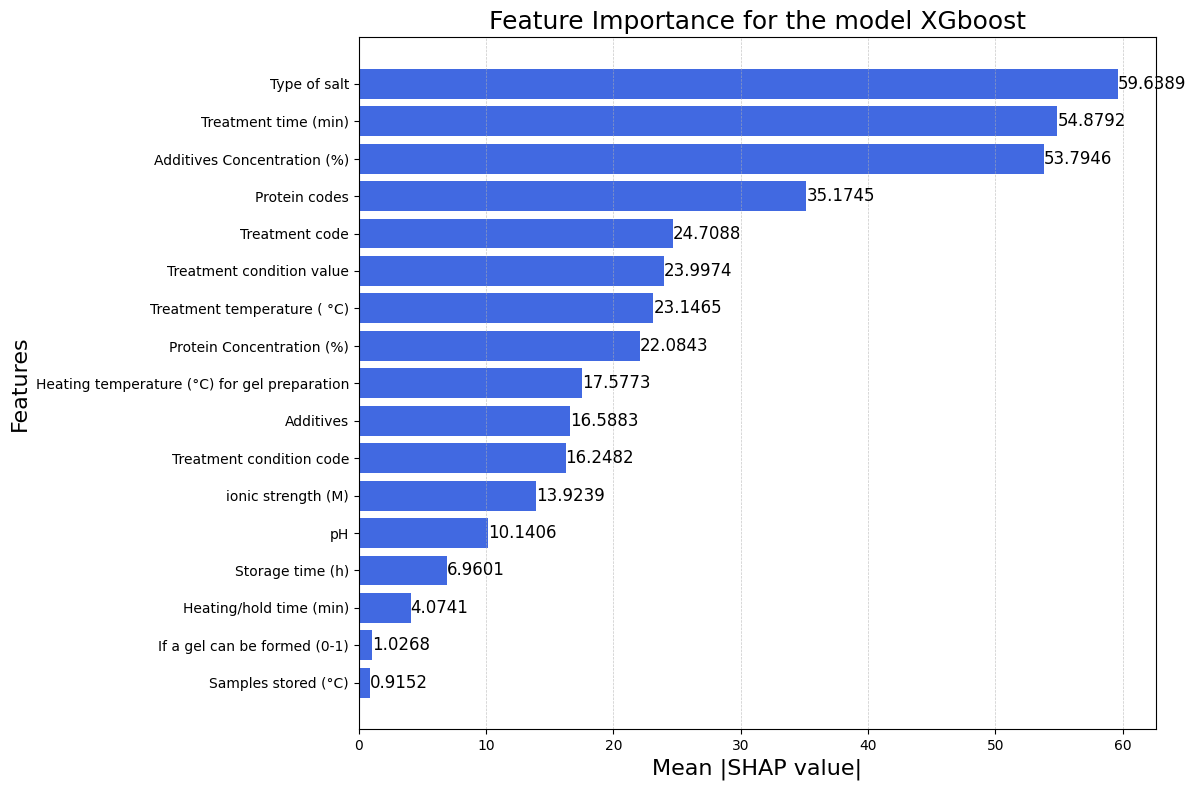

In [109]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Calcul des valeurs SHAP
explainer = shap.TreeExplainer(Xg_boost_model)
shap_values = explainer(X_test)

# Extraire les valeurs moyennes SHAP par caractéristique
shap_means = np.abs(shap_values.values).mean(axis=0)

# Trier les caractéristiques par importance
sorted_indices = np.argsort(shap_means)[::-1]

# Définir le nombre de caractéristiques à afficher
max_display = min(X_test.shape[1], 20)

# Préparer les données triées
sorted_shap_means = shap_means[sorted_indices][:max_display]
sorted_features = X_test.columns[sorted_indices][:max_display]

# Création du graphique en barres
plt.figure(figsize=(12, 8))

bars = plt.barh(sorted_features[::-1], sorted_shap_means[::-1], color='royalblue')

# Ajouter les valeurs sur les barres
for bar, value in zip(bars, sorted_shap_means[::-1]):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{value:.4f}',
             ha='left', va='center', fontsize=12, color='black')

plt.xlabel("Mean |SHAP value|", fontsize=16)
plt.ylabel("Features", fontsize=16)
plt.title("Feature Importance for the model XGboost", fontsize=18)
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

### Explanation for Technical Audience (Data Scientists):
This SHAP summary plot shows the average magnitude of SHAP values for features used in a **CatBoostRegressor model**. The SHAP value for each feature represents its contribution to the model's predictions. The features are ranked in descending order of importance based on their mean absolute SHAP values. 

- **"Ionic strength (M)"** has the highest importance, indicating it significantly impacts the model's predictions.
- Features like **"Samples stored (°C)"** and **"Type of salt"** also play crucial roles but are less influential compared to "Ionic strength."
- Features such as **"Additives"** and **"Protein codes"** have much smaller SHAP values, implying they contribute less to the prediction.

The results can guide feature engineering and domain understanding by highlighting which variables are driving the predictions.

---

### Explanation for Non-Technical Stakeholders:
This plot helps us understand which factors are most important for the predictions made by the model. Each bar represents how much a specific factor (like **"Ionic strength"** or **"Samples stored temperature"**) influences the model's outcomes on average.

- The top factor, **"Ionic strength"**, has the biggest influence, meaning it strongly affects how the predictions change.
- Factors like the **"storage temperature"** and the **"type of salt"** are also quite important, but less so than ionic strength.
- Factors lower down, like **"Additives"**, have very little impact on the model's predictions.

This information can help focus on the most critical factors for decision-making or further experimentation.

In [28]:
shap.initjs()
shap.plots.force(shap_values[0, ...])

In [30]:
shap.initjs()
shap.plots.force(shap_values[11, ...])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

### Using DiCE library for counterfactual explanations

In [40]:
import dice_ml
from dice_ml import Dice

d_gel = dice_ml.Data(dataframe=df_clean,
                      continuous_features=list(numerical_cols),
                      outcome_name='Hardness/firmness/strength (g)')

# We provide the type of model as a parameter (model_type)
catboost_with_preprocessing = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', CatBoostRegressor(random_state=RANDOM_STATE, verbose=False))])
catboost_with_preprocessing.fit(X_train, y_train)
m_gel = dice_ml.Model(model=catboost_with_preprocessing, backend="sklearn", model_type='regressor')
exp_genetic_gel = Dice(d_gel, m_gel, method="genetic")

In [32]:
import joblib
joblib.dump(Xg_boost_model, 'modelBoosting.joblib')

['modelBoosting.joblib']

In [33]:
import joblib
import numpy as np

# Charger le modèle
model = joblib.load(r"C:\Model_to_predict_GelHardness\Notebooks\modelBoosting.joblib")

# Exemple de données d'entrée
X_input = np.array([[
    50, 50.0, 5, 5, 50.0, 25, 5.0,
    1, 50.0, 7.0, 1, 0.5, 100, 60.0, 4,
    500, 0, 500.0
]])

# Prédiction
prediction = model.predict(X_input)

# Affichage du résultat
print(f"Prédiction du modèle : {prediction[0]:.2f}")


ValueError: Feature shape mismatch, expected: 17, got 18